# experiment. unsupervised learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
from tqdm import tqdm
tqdm.pandas()
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud

from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans

from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import networkx as nx
from gensim.models import KeyedVectors
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
from statsmodels.tsa.seasonal import STL

from mlxtend.frequent_patterns import apriori, association_rules

# suppress warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# from google.colab import drive
# drive.mount('/content/drive')
# df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/assets/complaints.csv')

In [2]:
filepath01 = 'complaints.csv'
filepath02 = 'GoogleNews-vectors-negative300.bin.gz'

DATA = pd.read_csv(filepath01)

## 1. LDA Topic Modeling on Consumer Complaints Narrative

use topic modeling (e.g., LDA) to identify common themes/topics from the narratives.

In [14]:
# make a copy of the data
df = DATA.copy()
print(df.shape)

# drop null narratives
df = df.dropna(subset=['Consumer complaint narrative'])
print(df.shape)


(4028530, 18)
(1460126, 18)


In [15]:
# draw random sample of 1/4 of the data for faster processing and demonstration purposes
df = df.sample(frac=0.25, random_state=42)
print(df.shape)

(365032, 18)


In [4]:
# preprocess the narrative column
def preprocess_narrative(text):
    # Lowercase
    text = text.lower()

    # Remove XXXX like pattern
    text = re.sub(r'x{2,}', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove stopwords
    text = " ".join([word for word in text.split() if word not in stop_words])

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)

    # Remove leading and trailing spaces
    text = text.strip()

    return text

In [17]:
# preprocess the narrative column to column 'narrative_clean'
df['narrative_clean'] = df['Consumer complaint narrative'].progress_apply(preprocess_narrative)

# check the result
df['narrative_clean'].sample(3).to_dict()

100%|██████████| 365032/365032 [00:45<00:00, 7988.12it/s]


{339305: 'reached seller asked washer dryer new didnt ask cell sent different pictures washer dryer asked could negotiate set sold said nevermind called said one new sent pics setup bring house brought new washer tried tell driver turnt washer rode said would talk didnt asked pick appliances could get money back instead insults rude different people tried help',
 2558048: 'may concern please note called fortiva personal loans requested due date changed end month got acknowledgment done yet harassing also reported delinquent credit report based original due date tried contact times always seems language barrier requesting due date honored month credit reports corrected please see attached documentation indicates inaccurate due dates thank cc ftc attorney general',
 3397981: 'duplicate complaint filed third party filing complaint please see complaint processed letter law regardless multiple written requests unverified public record listed still presenting credit report violation federal 

In [18]:
# Convert to a bag-of-words representation 
vectorizer = CountVectorizer(max_features=1000)

narrative_bow = vectorizer.fit_transform(df['narrative_clean'])

narrative_bow.shape

(365032, 1000)

In [19]:
# proceed with training the LDA model to identify topics within these narratives. 
# topics extracted from the complaint narratives, represented by the top 10 words associated with each topic.

# Training the LDA model
n_topics = 5
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42, max_iter=10)
lda_model.fit(narrative_bow)

LatentDirichletAllocation(n_components=5, random_state=42)

In [20]:
# Extracting topics and their top words
def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(tqdm(model.components_, desc='Processing topics', unit='topic')):
        topics.append(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
    return topics

# number of top words to display for each topic
no_top_words = 10

# get the feature names from the vectorizer object
feature_names = vectorizer.get_feature_names_out()

# get the topics and their top words
topics = display_topics(lda_model, feature_names, no_top_words)

# Print the topics
topics

Processing topics: 100%|██████████| 5/5 [00:00<00:00, 3054.40topic/s]


['account would bank told called payment received call back money',
 'consumer section reporting information usc account credit states agency report',
 'credit account card report accounts fraud dispute one never fraudulent',
 'credit report information debt reporting account accounts collection please balance',
 'loan credit payment payments late mortgage inquiry date due report']

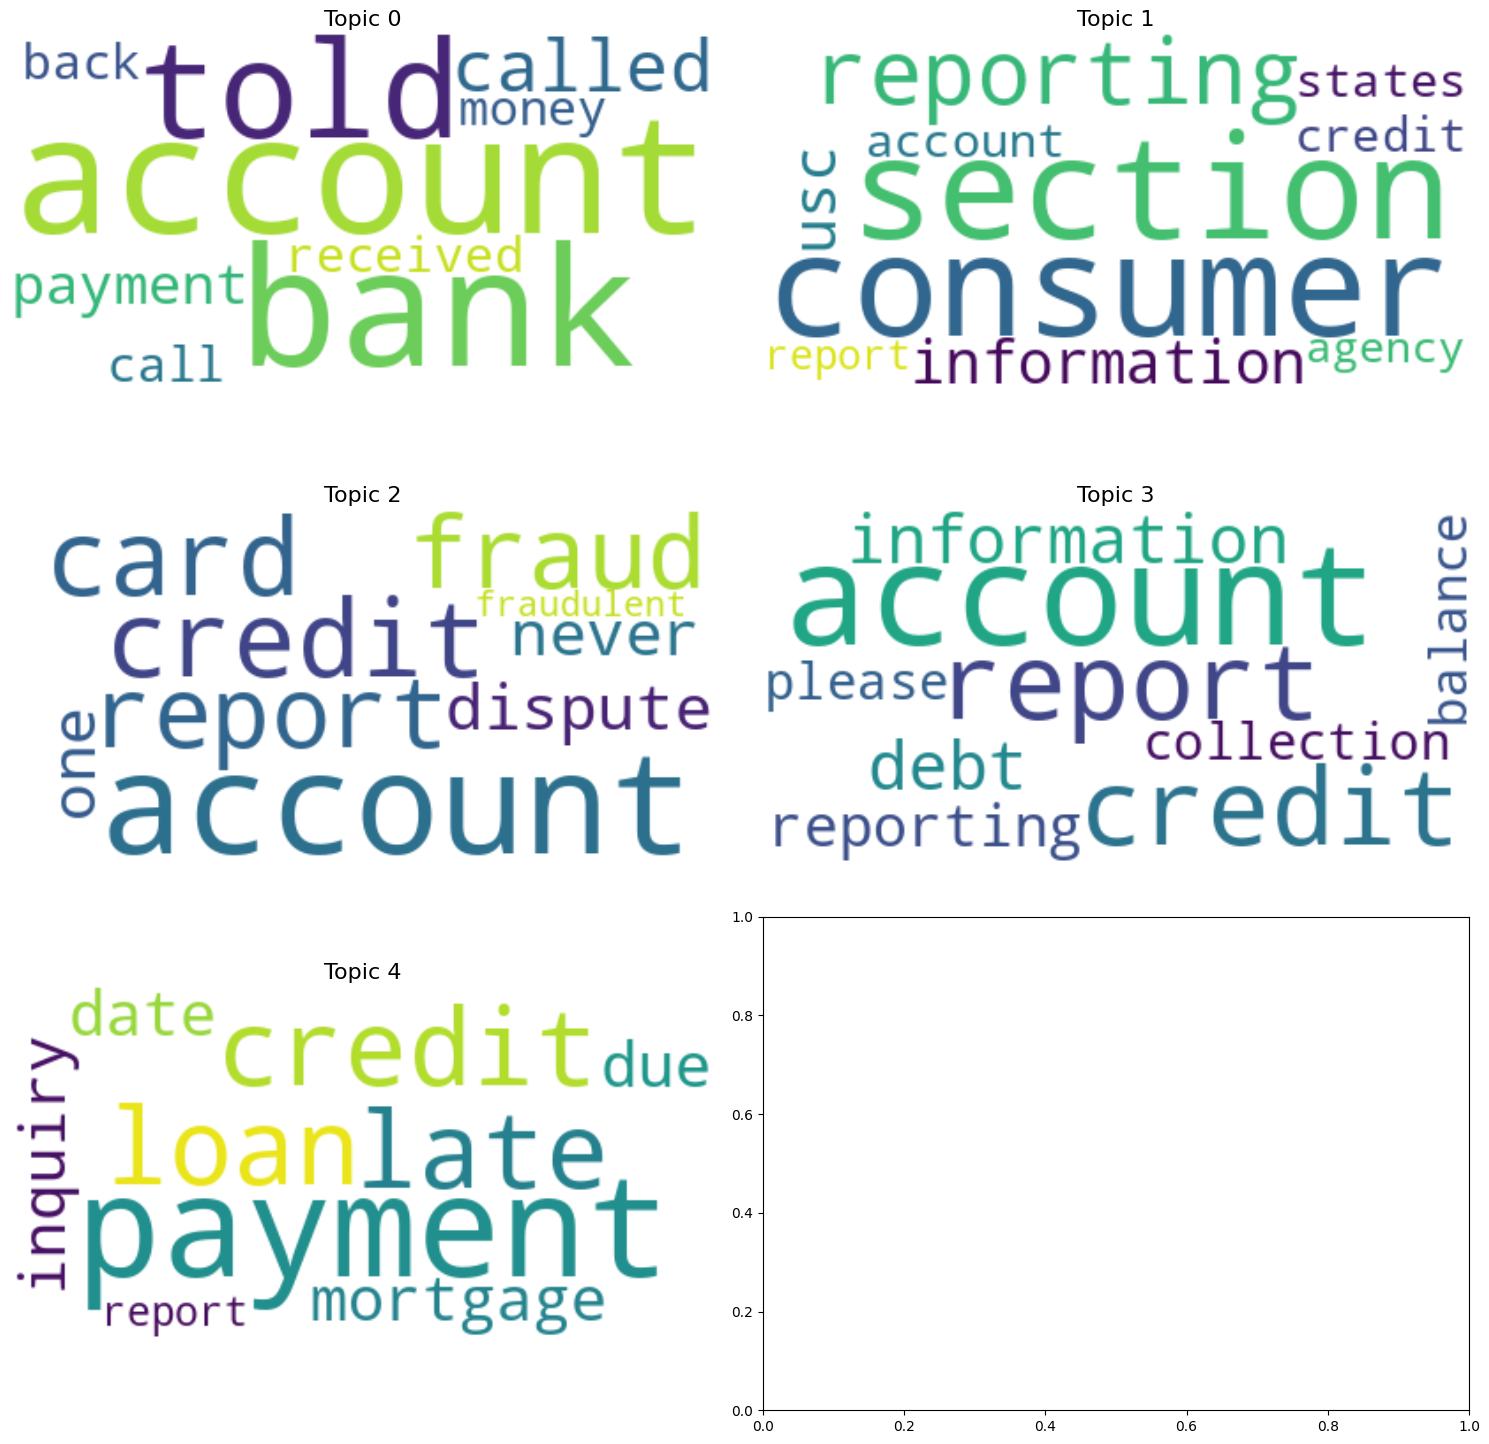

In [21]:
# function to generate word cloud for a given topic
def generate_wordcloud(topic, ax):
    wordcloud = WordCloud(background_color='white', max_words=50, contour_width=3, contour_color='steelblue')
    wordcloud.generate(topic)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')

# Visualizing the topics using word clouds
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

for i, ax in enumerate(axes.flatten()[:5]):

    # Generate word cloud for the topic
    generate_wordcloud(topics[i], ax)

    # Add topic as title for each subplot
    ax.set_title('Topic ' + str(i), fontdict=dict(size=16))

plt.tight_layout()

plt.show()


## 2. Clustering Complaints

convert the categorical variables ('Product', 'Issue', and 'Company') into a numerical format using one-hot encoding. Then, we'll apply a clustering algorithm, such as KMeans, to identify potential clusters.


In [31]:
# create a copy of the data
df2 = DATA.copy()

# drop null Product, Issue, and Company
df2 = df2.dropna(subset=['Product', 'Issue', 'Company'])

# draw random sample of 1/100 of the data for faster processing and demonstration purposes
df2 = df2.sample(frac=0.01, random_state=42)

# print shape
print(df2.shape)

(40285, 18)


In [32]:
encoder = OneHotEncoder(sparse=False)

# one hot encoding for Product, Issue, Company
encoded_data = encoder.fit_transform(df2[['Product', 'Issue', 'Company']])

encoded_data.shape

(40285, 1810)

Inertia measures compactness of clustering. Lower is better.
The Elbow Method finds the "sweet spot" where adding more clusters does not significantly improve inertia.
It balances between too few and too many clusters.

100%|██████████| 14/14 [02:16<00:00,  9.72s/it]


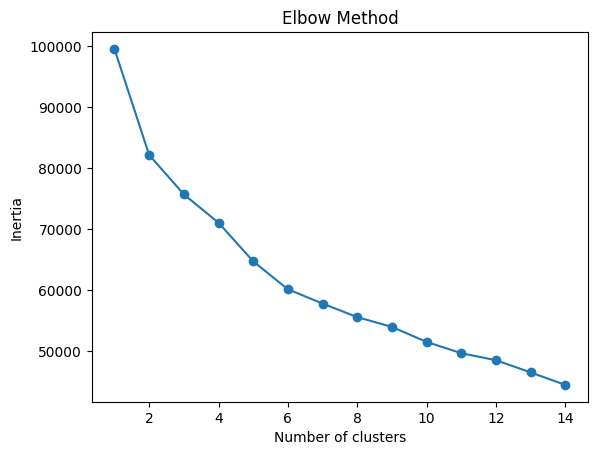

In [35]:
# Determine the optimal number of clusters using the Elbow Method

inertia = []

for i in tqdm(range(1, 15)):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(encoded_data)
    inertia.append(kmeans.inertia_)

# Plot the inertia values against k
plt.plot(range(1, 15), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()



In [36]:
# Train the KMeans model with 8 clusters
kmeans = KMeans(n_clusters=8, random_state=42)

# fit the model to the encoded data
kmeans.fit(encoded_data)

# get the cluster labels
cluster_labels = kmeans.labels_

# print the cluster labels
cluster_labels

# assign the cluster labels to the  data
df2['cluster'] = cluster_labels


In [41]:
#   What are the top products and issues combinations in each cluster?

# get the top 5 products and issues in each cluster
top_products_issues = df2.groupby('cluster').apply(lambda x: x.groupby(['Product', 'Issue']).size().sort_values(ascending=False).head(5))

# print the top products and issues in each cluster
top_products_issues

cluster  Product                                                                       Issue                                                                           
0        Checking or savings account                                                   Managing an account                                                                 1082
                                                                                       Closing an account                                                                   213
                                                                                       Problem with a lender or other company charging your account                         173
                                                                                       Opening an account                                                                   143
                                                                                       Problem caused by your funds being low   

## 3. Dimensionality Reduction and Visualization 

use t-SNE (t-distributed Stochastic Neighbor Embedding) to reduce the dimensionality of the categorical data and visualize it. 

In [57]:
# create a copy of the data
df3 = DATA.copy()

In [58]:
# sample 1/100 of the data for faster processing and demonstration purposes
df3 = df3.sample(frac=0.01, random_state=42)

# print sh
print(df3.shape)

(40285, 18)


In [59]:
# subset to: Product, Issue, Company, State, Company response to consumer, public response, Tags. 
df3 = df3[['Product', 'Issue', 'Company', 'State', 'Company response to consumer', 'Tags', 'Company public response']]

# fill null values with 'Not provided'
df3 = df3.fillna('Not provided')

# print shape
print(df3.shape)

(40285, 7)


In [60]:
# one hot encoding
encoded_data = pd.get_dummies(df3)

encoded_data.shape

(40285, 1896)

In [61]:
# Reduce the dimensionality of the data to 2 dimensions using t-SNE

tsne_model = TSNE(n_components=2, perplexity=50, random_state=42)
tsne_values = tsne_model.fit_transform(encoded_data)

tsne_values.shape

(40285, 2)

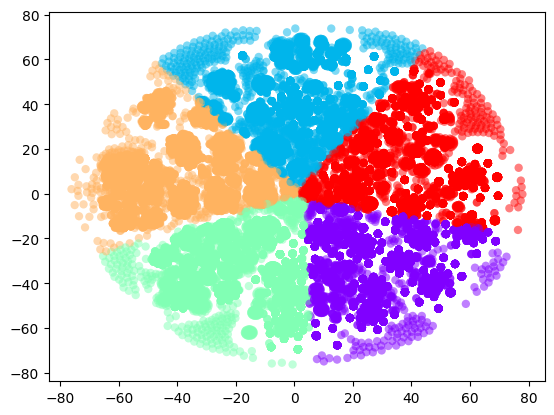

In [62]:
# Visualize the tsne values with different colors for each cluster
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(tsne_values)

plt.scatter(tsne_values[:, 0], tsne_values[:, 1], c=kmeans.labels_, cmap='rainbow', edgecolors='none', alpha=0.5)
plt.show()

## 4. Anomaly Detection

In [63]:
df4 = DATA.copy()

In [64]:
# sample 1/100 of the data for faster processing and demonstration purposes

df4 = df4.sample(frac=0.01, random_state=42)

# print shape

print(df4.shape)



(40285, 18)


In [65]:
# subset to: Product, Issue, Company, company response to consumer, public response

df4 = df4[['Product', 'Issue', 'Company', 'Company response to consumer', 'Company public response']]

# fill null values with 'Not provided'

df4 = df4.fillna('Not provided')

# print shape

print(df4.shape)

(40285, 5)


In [66]:
n=20

top_products = df4['Product'].value_counts().index[:n].tolist()
df4['Product_other'] = df4['Product'].apply(lambda x: x if x in top_products else 'Other')

top_issues = df4['Issue'].value_counts().index[:n].tolist()
df4['Issue_other'] = df4['Issue'].apply(lambda x: x if x in top_issues else 'Other')

top_companies = df4['Company'].value_counts().index[:n].tolist()
df4['Company_other'] = df4['Company'].apply(lambda x: x if x in top_companies else 'Other')

top_company_responses = df4['Company response to consumer'].value_counts().index[:n].tolist()
df4['Company response to consumer_other'] = df4['Company response to consumer'].apply(lambda x: x if x in top_company_responses else 'Other')

top_public_responses = df4['Company public response'].value_counts().index[:n].tolist()
df4['Company public response_other'] = df4['Company public response'].apply(lambda x: x if x in top_public_responses else 'Other')


In [67]:
# one hot encoding

encoded_data = pd.get_dummies(df4)

encoded_data.shape



(40285, 1912)

In [68]:
# Train the Isolation Forest model

isolation_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)

isolation_forest.fit(encoded_data)


IsolationForest(contamination=0.01, random_state=42)

In [69]:
# predict the anomalies / outliers
outlier_preds = isolation_forest.predict(encoded_data)

# add the predictions as a new column to the data
df4['outlier'] = outlier_preds

# print the number of outliers
print(df4['outlier'].value_counts())

 1    39887
-1      398
Name: outlier, dtype: int64


In [70]:
# print the outliers
df4[df4['outlier'] == -1].head(10)

,Product,Issue,Company,Company response to consumer,Company public response,Product_other,Issue_other,Company_other,Company response to consumer_other,Company public response_other,outlier
478551,Credit card or prepaid card,Problem with a purchase shown on your statement,"CITIBANK, N.A.",Closed with monetary relief,Company has responded to the consumer and the ...,Credit card or prepaid card,Problem with a purchase shown on your statement,"CITIBANK, N.A.",Closed with monetary relief,Company has responded to the consumer and the ...,-1
1393374,Credit card,Rewards,"CITIBANK, N.A.",Closed with monetary relief,Company chooses not to provide a public response,Credit card,Other,"CITIBANK, N.A.",Closed with monetary relief,Company chooses not to provide a public response,-1
2343768,Bank account or service,"Account opening, closing, or management","SANTANDER BANK, NATIONAL ASSOCIATION",Closed,Company chooses not to provide a public response,Bank account or service,"Account opening, closing, or management",Other,Closed,Company chooses not to provide a public response,-1
1427596,Credit card,Identity theft / Fraud / Embezzlement,"CITIBANK, N.A.",Closed with monetary relief,Company has responded to the consumer and the ...,Credit card,Other,"CITIBANK, N.A.",Closed with monetary relief,Company has responded to the consumer and the ...,-1
2552213,Credit card,Delinquent account,"CITIBANK, N.A.",Closed with monetary relief,Company has responded to the consumer and the ...,Credit card,Other,"CITIBANK, N.A.",Closed with monetary relief,Company has responded to the consumer and the ...,-1
2711914,Credit card,Billing disputes,"CITIBANK, N.A.",Closed with monetary relief,Company chooses not to provide a public response,Credit card,Other,"CITIBANK, N.A.",Closed with monetary relief,Company chooses not to provide a public response,-1
325276,Checking or savings account,Managing an account,"BANK OF AMERICA, NATIONAL ASSOCIATION",Closed with monetary relief,Company has responded to the consumer and the ...,Checking or savings account,Managing an account,"BANK OF AMERICA, NATIONAL ASSOCIATION",Closed with monetary relief,Company has responded to the consumer and the ...,-1
1020277,Credit card or prepaid card,Improper use of your report,SYNCHRONY FINANCIAL,Closed with non-monetary relief,Company has responded to the consumer and the ...,Credit card or prepaid card,Improper use of your report,SYNCHRONY FINANCIAL,Closed with non-monetary relief,Company has responded to the consumer and the ...,-1
3605362,Bank account or service,"Account opening, closing, or management","CITIBANK, N.A.",Closed with non-monetary relief,Company has responded to the consumer and the ...,Bank account or service,"Account opening, closing, or management","CITIBANK, N.A.",Closed with non-monetary relief,Company has responded to the consumer and the ...,-1
1523117,Checking or savings account,Managing an account,"BANK OF AMERICA, NATIONAL ASSOCIATION",Closed with monetary relief,Company has responded to the consumer and the ...,Checking or savings account,Managing an account,"BANK OF AMERICA, NATIONAL ASSOCIATION",Closed with monetary relief,Company has responded to the consumer and the ...,-1


In [71]:
# the question is: are these outliers truly anomalous or are they just rare events?
# how do we judge 

## 5. Association rule mining
mining association rules between the product and issue categories.


In [72]:
# create a copy of the data
df5 = DATA.copy()

In [73]:
# subset product and issue

df5 = df5[['Product', 'Issue']]

# drop null values

df5 = df5.dropna()

# print shape

print(df5.shape)

(4028530, 2)


In [78]:
df5.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    2162845
Debt collection                                                                  503401
Mortgage                                                                         383137
Credit card or prepaid card                                                      205725
Checking or savings account                                                      180437
Credit reporting                                                                 140429
Credit card                                                                       89569
Bank account or service                                                           86205
Student loan                                                                      76153
Money transfer, virtual currency, or money service                                58142
Vehicle loan or lease                                                             47080
Consumer Loan                   

In [79]:
df5.Issue.value_counts()

Incorrect information on your report                                                1043871
Problem with a credit reporting company's investigation into an existing problem     589095
Improper use of your report                                                          517504
Attempts to collect debt not owed                                                    180328
Loan modification,collection,foreclosure                                             112306
                                                                                     ...   
Didn't provide services promised                                                          4
Lender damaged or destroyed property                                                      3
Trouble accessing funds in your mobile or digital wallet                                  2
Charged upfront or unexpected fees                                                        1
Unauthorized withdrawals or charges                                             

In [80]:
# one hot encoding then convert to dataframe for apriori

encoded_data = pd.get_dummies(df5)

encoded_data = pd.DataFrame(encoded_data, columns=encoded_data.columns)

encoded_data.shape

(4028530, 193)

In [81]:
# Train the Apriori model

frequent_itemsets = apriori(encoded_data, min_support=0.01, use_colnames=True)

# print the frequent itemsets
frequent_itemsets

,support,itemsets
0,0.021399,(Product_Bank account or service)
1,0.044790,(Product_Checking or savings account)
2,0.022234,(Product_Credit card)
3,0.051067,(Product_Credit card or prepaid card)
4,0.034859,(Product_Credit reporting)
5,0.536882,"(Product_Credit reporting, credit repair servi..."
6,0.124959,(Product_Debt collection)
7,0.014433,"(Product_Money transfer, virtual currency, or ..."
8,0.095106,(Product_Mortgage)
9,0.018903,(Product_Student loan)


In [82]:
# Generate the association rules

rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)

In [113]:
# print the association rules, sorted by lift

top_10_rules = rules.sort_values(by='lift', ascending=False)

top_10_rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
4,(Issue_Incorrect information on credit report),(Product_Credit reporting),0.025489,0.034859,0.025489,1.000000,28.687308,0.024601,inf
5,(Product_Credit reporting),(Issue_Incorrect information on credit report),0.034859,0.025489,0.025489,0.731216,28.687308,0.024601,3.625635
0,(Issue_Managing an account),(Product_Checking or savings account),0.027522,0.044790,0.027522,1.000000,22.326518,0.026289,inf
1,(Product_Checking or savings account),(Issue_Managing an account),0.044790,0.027522,0.027522,0.614469,22.326518,0.026289,2.522440
2,(Issue_Problem with a purchase shown on your s...,(Product_Credit card or prepaid card),0.012643,0.051067,0.012636,0.999450,19.571347,0.011990,1726.142991
3,(Product_Credit card or prepaid card),(Issue_Problem with a purchase shown on your s...,0.051067,0.012643,0.012636,0.247442,19.571347,0.011990,1.312001
25,"(Issue_Loan servicing, payments, escrow account)",(Product_Mortgage),0.019195,0.095106,0.019195,1.000000,10.514594,0.017370,inf
24,(Product_Mortgage),"(Issue_Loan servicing, payments, escrow account)",0.095106,0.019195,0.019195,0.201831,10.514594,0.017370,1.228819
23,(Product_Mortgage),"(Issue_Loan modification,collection,foreclosure)",0.095106,0.027878,0.027878,0.293122,10.514594,0.025226,1.375234
22,"(Issue_Loan modification,collection,foreclosure)",(Product_Mortgage),0.027878,0.095106,0.027878,1.000000,10.514594,0.025226,inf


The higher the lift, the stronger the association between the antecedent(s) and consequent(s). High confidence also indicates a strong rule. Support shows the frequency of occurrence.

Row 5: This rule indicates that when the antecedent is "Product-Credit reporting," there's a support of 0.025, meaning that this product is found in about 2.5% of the transactions. The confidence is 0.731, which means that there's a 73.1.8% chance of "Issue-Incorrect information on credit report" occurring when "Product-Credit reporting" is present. The lift is 28.68, which is quite high, indicating a strong positive association between these two items, 28x more often than if they were independent.

In [115]:
# process text in antecedents and consequents

def process_text(text):
    
    # replace Product_ and Issue_ with [Product] and [Issue]
    text = re.sub(r'Product_', '[Product]', text)
    text = re.sub(r'Issue_', '[Issue]', text)
    
    pattern = r"'(.*?)'"
    match = re.search(pattern, text)
        
    if match:
        return match.group(1)
    else:
        return text



# astype antececdents, consequents to string
top_10_rules['antecedents'] = top_10_rules['antecedents'].astype(str)
top_10_rules['consequents'] = top_10_rules['consequents'].astype(str)

# apply process_text to antecedents and consequents
top_10_rules['antecedents'] = top_10_rules['antecedents'].apply(process_text)
top_10_rules['consequents'] = top_10_rules['consequents'].apply(process_text)

top_10_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
4,[Issue]Incorrect information on credit report,[Product]Credit reporting,0.025489,0.034859,0.025489,1.000000,28.687308,0.024601,inf
5,[Product]Credit reporting,[Issue]Incorrect information on credit report,0.034859,0.025489,0.025489,0.731216,28.687308,0.024601,3.625635e+00
0,[Issue]Managing an account,[Product]Checking or savings account,0.027522,0.044790,0.027522,1.000000,22.326518,0.026289,inf
1,[Product]Checking or savings account,[Issue]Managing an account,0.044790,0.027522,0.027522,0.614469,22.326518,0.026289,2.522440e+00
2,[Issue]Problem with a purchase shown on your s...,[Product]Credit card or prepaid card,0.012643,0.051067,0.012636,0.999450,19.571347,0.011990,1.726143e+03
3,[Product]Credit card or prepaid card,[Issue]Problem with a purchase shown on your s...,0.051067,0.012643,0.012636,0.247442,19.571347,0.011990,1.312001e+00
25,"[Issue]Loan servicing, payments, escrow account",[Product]Mortgage,0.019195,0.095106,0.019195,1.000000,10.514594,0.017370,inf
24,[Product]Mortgage,"[Issue]Loan servicing, payments, escrow account",0.095106,0.019195,0.019195,0.201831,10.514594,0.017370,1.228819e+00
23,[Product]Mortgage,"[Issue]Loan modification,collection,foreclosure",0.095106,0.027878,0.027878,0.293122,10.514594,0.025226,1.375234e+00
22,"[Issue]Loan modification,collection,foreclosure",[Product]Mortgage,0.027878,0.095106,0.027878,1.000000,10.514594,0.025226,inf


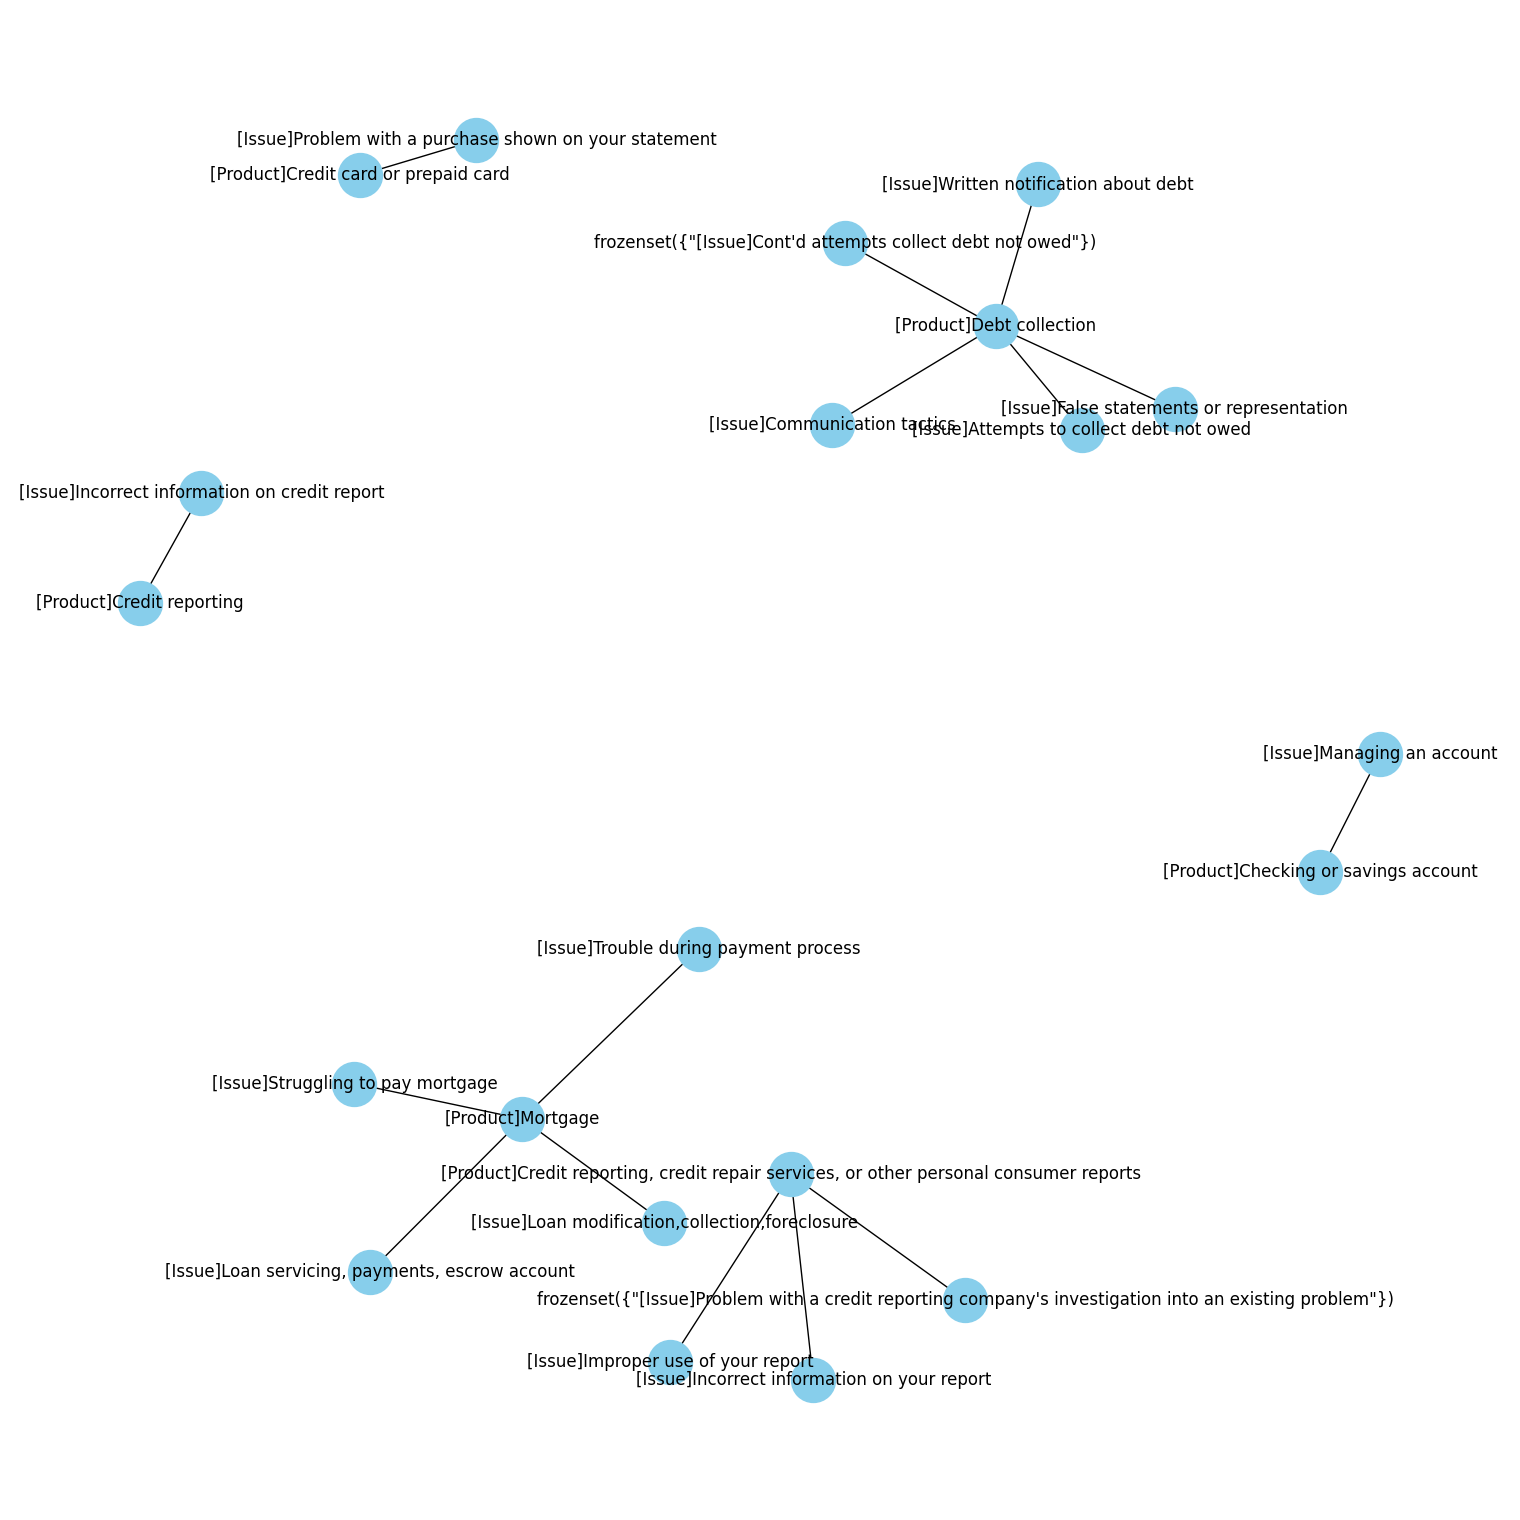

In [116]:
# network graph of the association rules

# create a network graph of the association rules

G = nx.from_pandas_edgelist(top_10_rules, source='antecedents', target='consequents', edge_attr=True)

# set the size of the figure

plt.figure(figsize=(15, 15))

# plot the network graph of the association rules

nx.draw(G, with_labels=True, node_size=1000, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=nx.spring_layout(G, k=0.5, iterations=50))

plt.show()



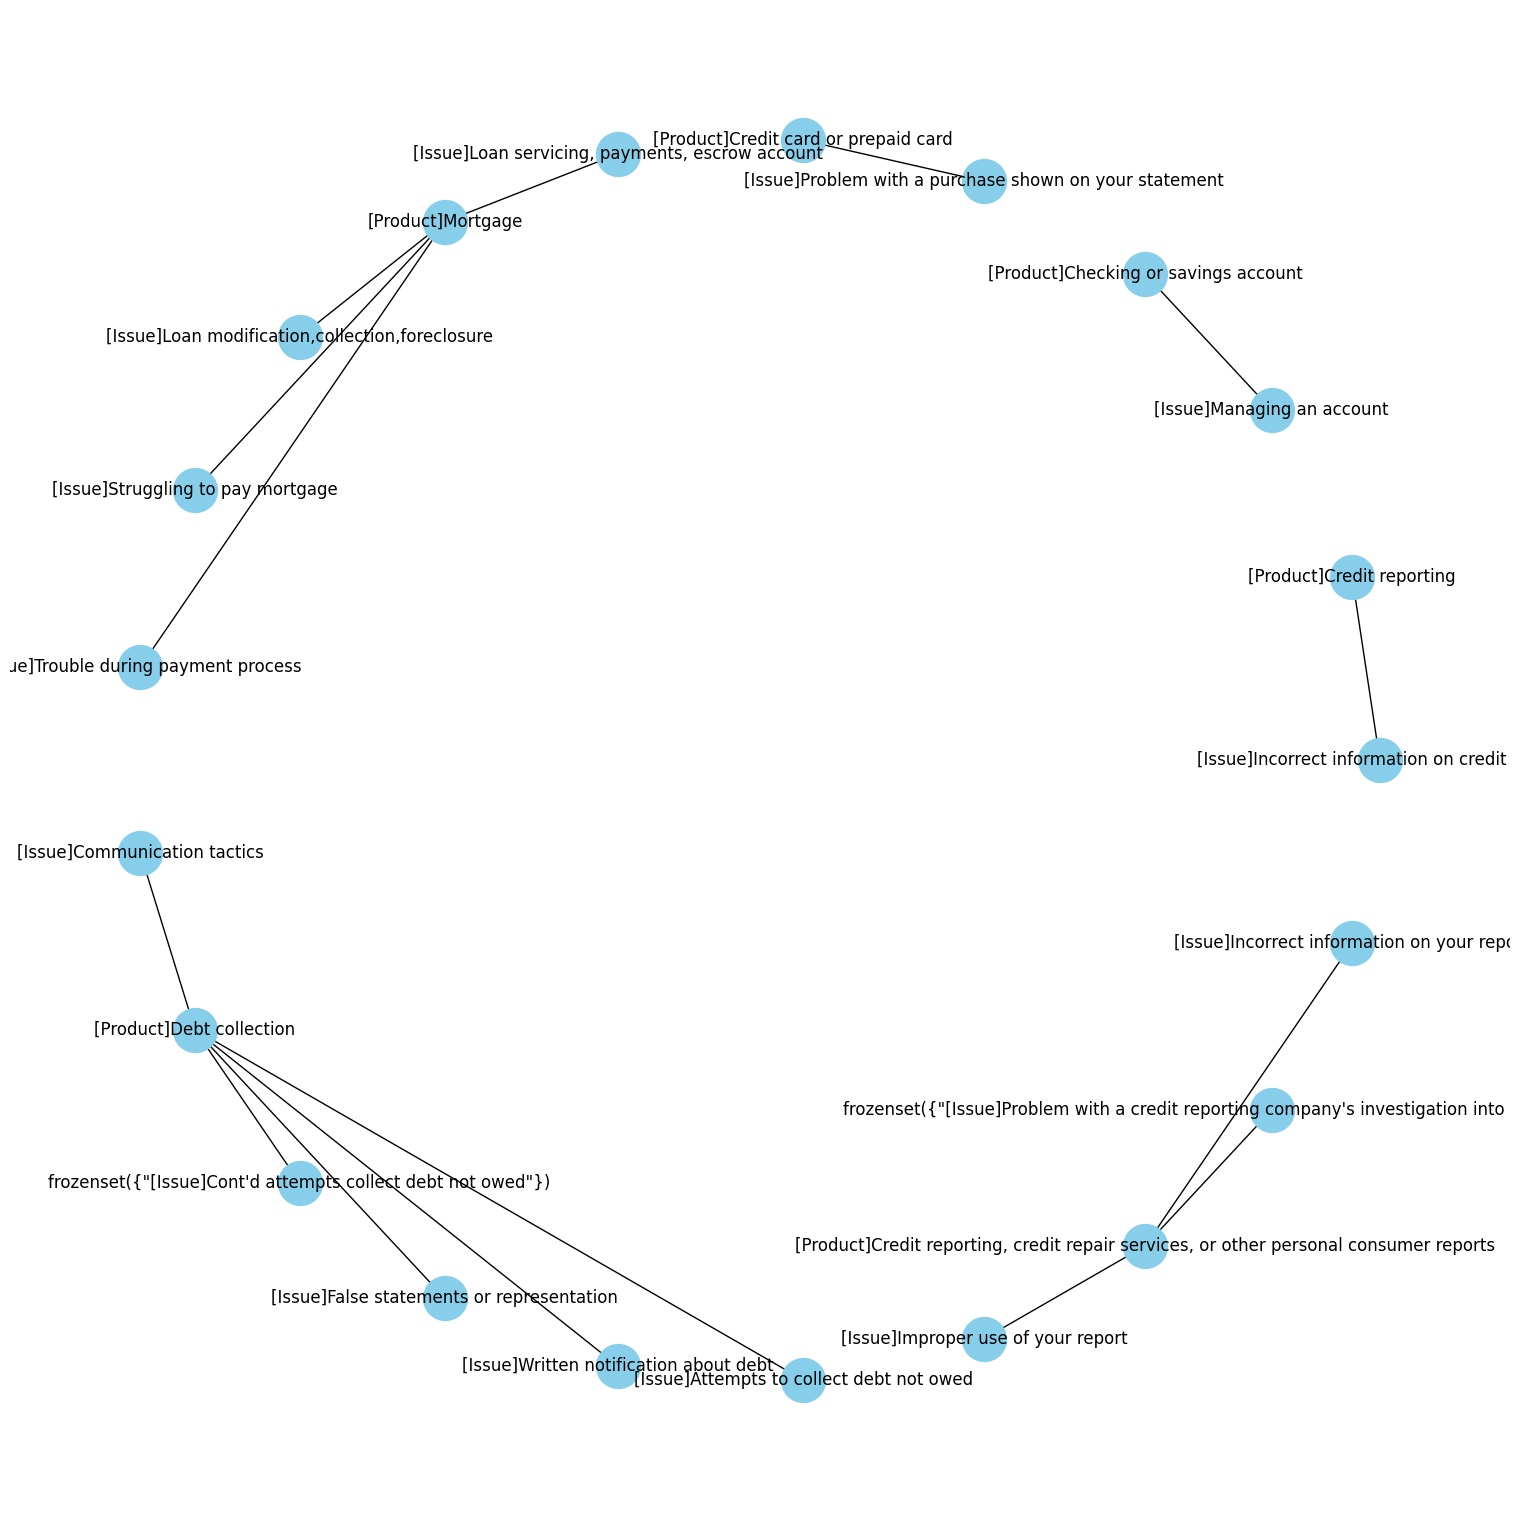

In [117]:
# try a different layout

plt.figure(figsize=(15, 15))

nx.draw(G, with_labels=True, node_size=1000, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=nx.circular_layout(G))

plt.show()



## 6. SVD dimensionality reduction and visualization on Narrative

use SVD (Singular Value Decomposition) to reduce the dimensionality of the narrative data and visualize it.

In [9]:
# create a copy of the data
df6 = DATA.copy()

# drop null narratives
df6 = df6.dropna(subset=['Consumer complaint narrative'])

# subset 1/100 of the data for faster processing and demonstration purposes
df6 = df6.sample(frac=0.01, random_state=42)

# subset to narrative
df6 = df6[['Consumer complaint narrative']]

# preprocess the narrative column
df6['narrative_clean'] = df6['Consumer complaint narrative'].progress_apply(preprocess_narrative)

# print shape
print(df6.shape)

100%|██████████| 14601/14601 [00:01<00:00, 8648.22it/s]

(14601, 2)


In [10]:
# tf-idf vectorization

vectorizer = TfidfVectorizer(max_features=5000)

narrative_tfidf = vectorizer.fit_transform(df6['narrative_clean'])

# print shape
print(narrative_tfidf.shape)

(14601, 5000)


In [11]:
# dimensionality reduction using SVD

svd = TruncatedSVD(n_components=50, random_state=42)

svd_values = svd.fit_transform(narrative_tfidf)

# print shape
print(svd_values.shape)


(14601, 50)


In [13]:
# apply t-SNE to the SVD values
tsne_model = TSNE(n_components=2, random_state=42)
tsne_values = tsne_model.fit_transform(svd_values)

# print shape
print(tsne_values.shape)

(14601, 2)


In [21]:
# k mean on svd values

kmeans = KMeans(n_clusters=5, random_state=42)

kmeans.fit(svd_values)

# get the cluster labels

cluster_labels = kmeans.labels_

# assign the cluster labels to the data

df6['cluster'] = cluster_labels



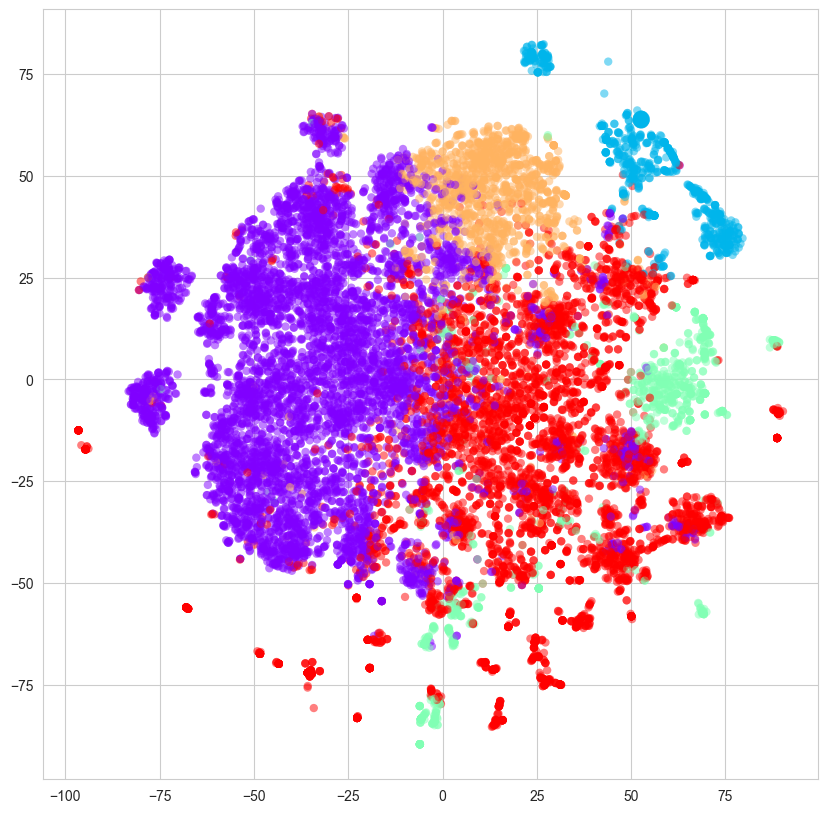

In [22]:
# Visualize the Clusters, Create a scatter plot

plt.figure(figsize=(10, 10))
plt.scatter(tsne_values[:, 0], tsne_values[:, 1], c=df6['cluster'], cmap='rainbow', edgecolors='none', alpha=0.5)
plt.show()



## 7. Time Series 

In [23]:
# create a copy of the data

data = DATA.copy()

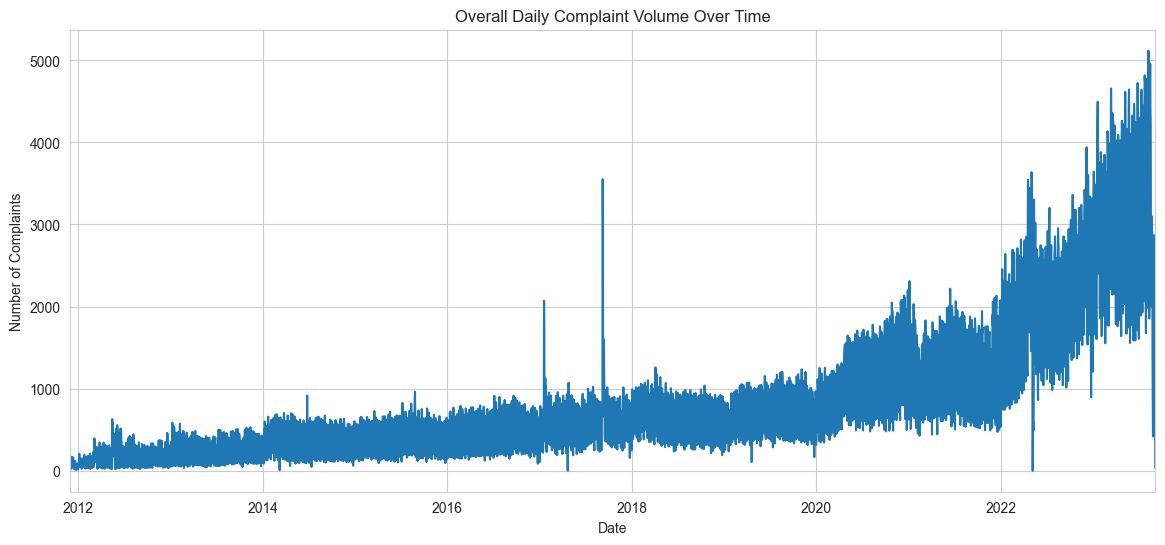

In [29]:
# overall daily number of complaints over time

# Resample data to get daily complaint counts
daily_complaints = data.resample('D', on='Date received').size()

# Plot overall complaint volume over time
plt.figure(figsize=(14, 6))
daily_complaints.plot()
plt.title('Overall Daily Complaint Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.grid(True)
plt.show()


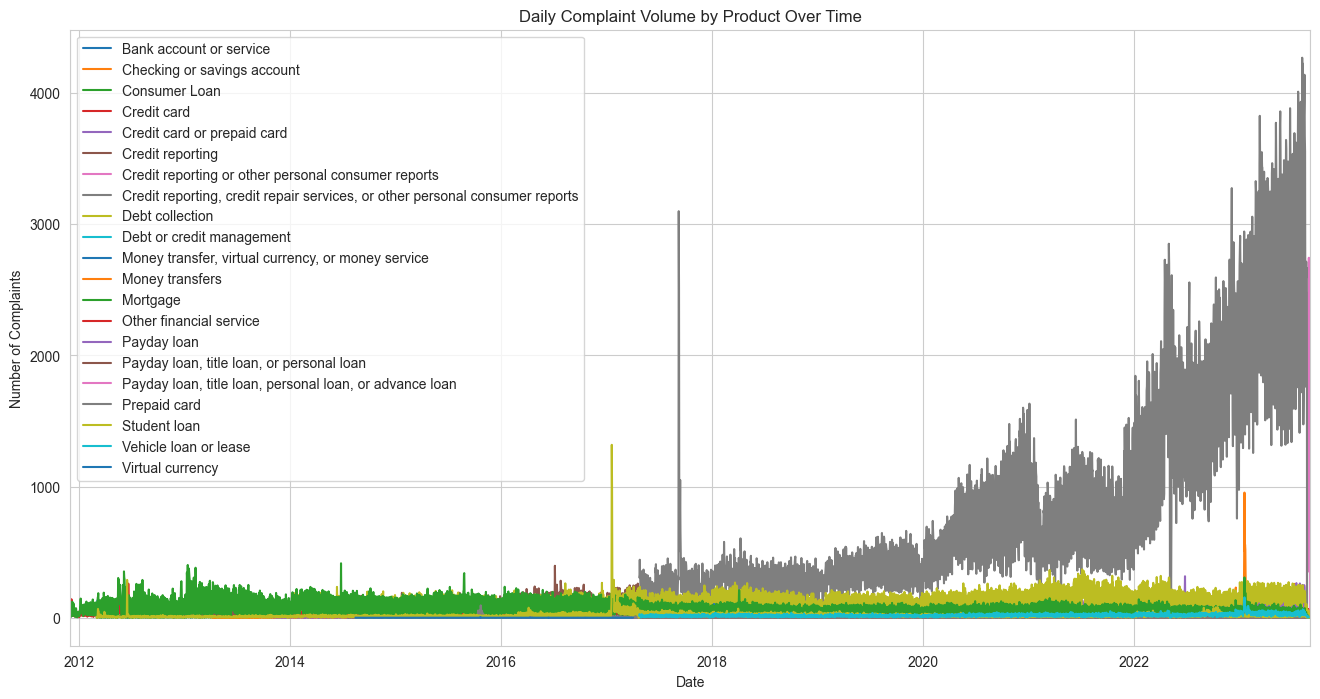

In [30]:
# Resample data to get daily complaint counts by Product
daily_complaints_by_product = data.groupby('Product').resample('D', on='Date received').size().unstack(0)

# Plot daily complaint volume by Product
plt.figure(figsize=(16, 8))
for product in daily_complaints_by_product.columns:
    daily_complaints_by_product[product].plot(label=product)

plt.title('Daily Complaint Volume by Product Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.legend()
plt.grid(True)
plt.show()


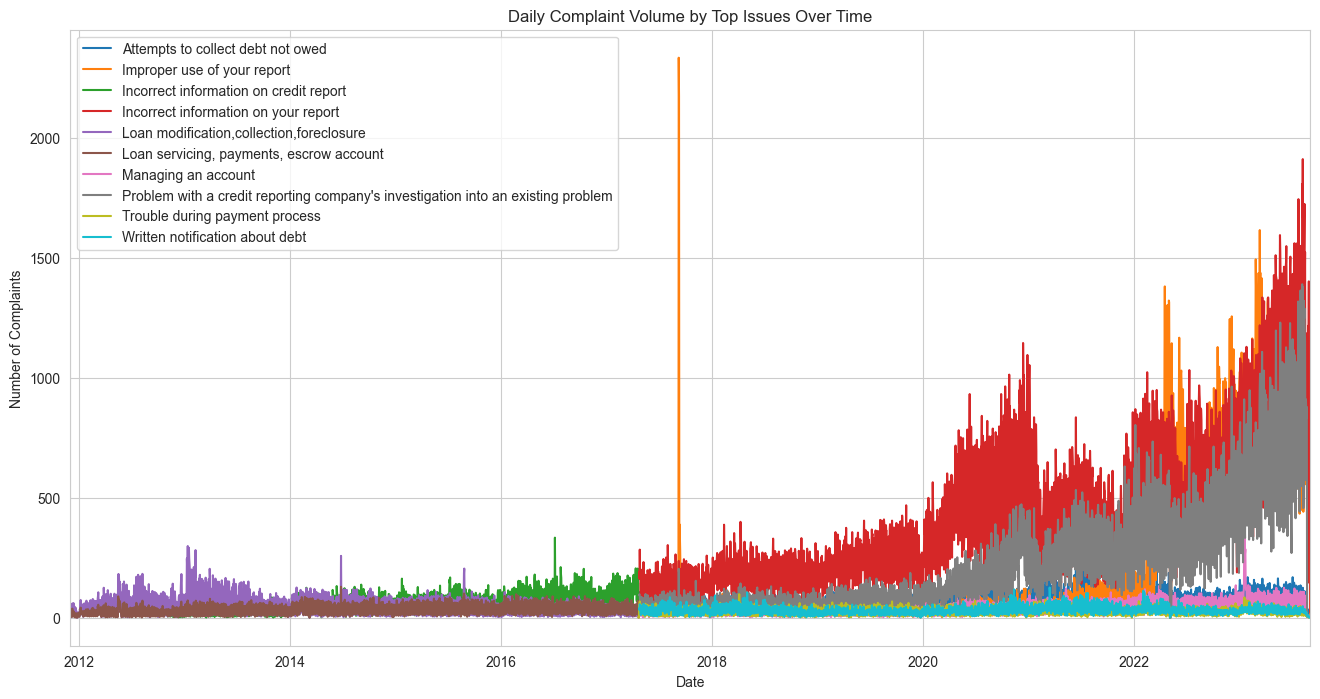

In [31]:
# Top N issues by overall complaint volume

N = 10
top_issues = data['Issue'].value_counts().head(N).index

# Filter data to include only the top N issues
data_top_issues = data[data['Issue'].isin(top_issues)]

# Resample data to get daily complaint counts by Issue
daily_complaints_by_issue = data_top_issues.groupby('Issue').resample('D', on='Date received').size().unstack(0)

# Plot daily complaint volume by Issue
plt.figure(figsize=(16, 8))
for issue in daily_complaints_by_issue.columns:
    daily_complaints_by_issue[issue].plot(label=issue)

plt.title('Daily Complaint Volume by Top Issues Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.legend()
plt.grid(True)
plt.show()


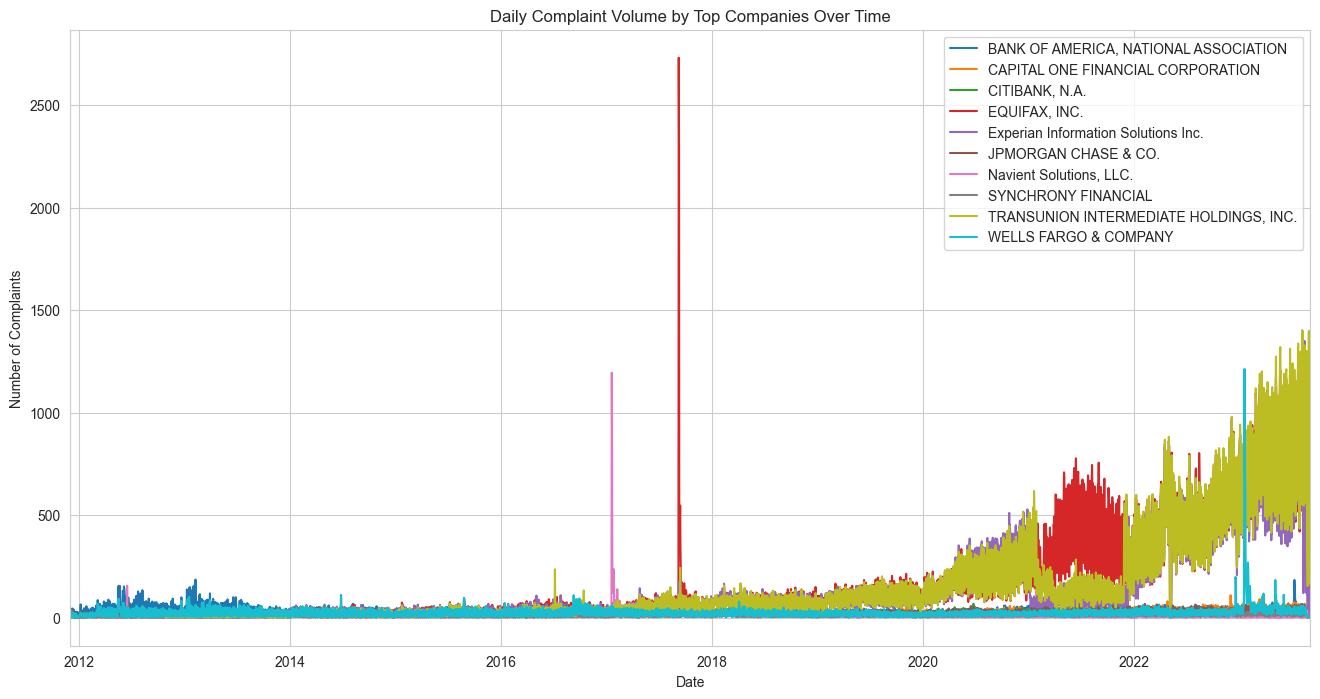

In [32]:
# Top N companies by overall complaint volume
N = 10
top_companies = data['Company'].value_counts().head(N).index

# Filter data to include only the top N companies
data_top_companies = data[data['Company'].isin(top_companies)]

# Resample data to get daily complaint counts by Company
daily_complaints_by_company = data_top_companies.groupby('Company').resample('D', on='Date received').size().unstack(0)

# Plot daily complaint volume by Company
plt.figure(figsize=(16, 8))
for company in daily_complaints_by_company.columns:
    daily_complaints_by_company[company].plot(label=company)

plt.title('Daily Complaint Volume by Top Companies Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.legend()
plt.grid(True)
plt.show()


### STL Decomposition of Daily Complaint Volume

- Observed: This is the original time series data, showing the overall daily complaint volume.

- Trend: This component captures the underlying trend in the data. From the plot, you can observe any gradual increase, decrease, or stagnation over time.

- Seasonal: This component captures any repeated patterns or fluctuations that occur at regular intervals. If there's any weekly or monthly seasonality, it would be evident here.

- Resid: This represents the residuals or "noise" after removing the trend and seasonal components. the residuals should appear as random white noise.

From the decomposition, you can observe if there are any consistent patterns, seasonality, or trends in the complaint volumes. This can help in anticipating future volumes, identifying anomalies, and formulating appropriate complaint response strategies.

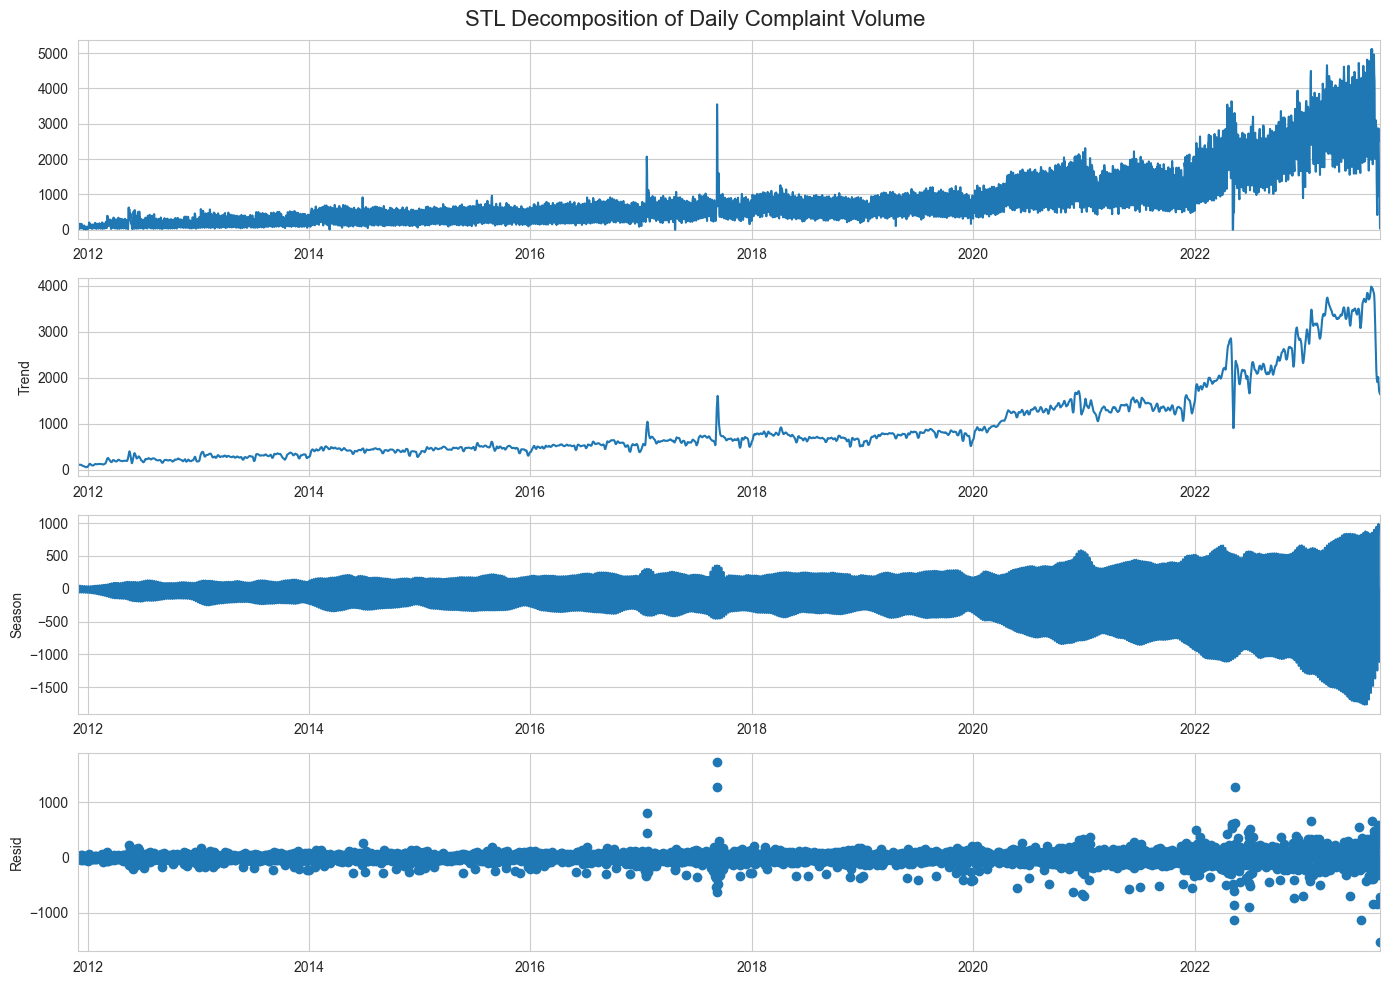

In [33]:
# decompose a time series into several components
#  use the STL (Seasonal-Trend decomposition using LOESS) method for this decomposition 

# Decompose the overall daily complaints series
stl = STL(daily_complaints, seasonal=13)
result = stl.fit()

# Plot the decomposed components
fig = result.plot()
fig.set_size_inches(14, 10)
fig.suptitle('STL Decomposition of Daily Complaint Volume', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()
